In [1]:
# import keras dependencies 
from keras.models import Model
from keras.applications import MobileNet as CNN
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.neighbors import NearestNeighbors
import numpy as np
from IPython.display import Image 
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Load model pre-trained on `ImageNet` dataset

In [2]:
model = CNN(include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

The above network loads the `MobileNet` model trained on _ImageNet_. We will try and adapt this architecture which is generally effective in classifying images towards exploring features in our de-duplicaion database.
#### Slice network to limit output features
We can now eyeball the function of all network layers in the model. To limit the number of our output features we cut the network off at `Layer(-3)`.

In [3]:
model_slice = Model(inputs=model.input, outputs=model.layers[-3].output)
model_slice.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

This outputs a vector of size `(1, 1, 1000)` for each input image.
#### Ingest test dataset to de-duplicate

In [4]:
img_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
IMG_DIR_TRAIN = '/Users/zubin.john/forge/image-dedup/tests/data/convnet_images'


img_batches_train = img_gen_train.flow_from_directory(
    directory=IMG_DIR_TRAIN,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False
)

docs = [doc for doc in os.listdir(f'{IMG_DIR_TRAIN}/0') if doc.endswith('.jpg')]
feat_vecs_train = model_slice.predict_generator(img_batches_train, len(img_batches_train), verbose=1)

Found 13 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step


#### Use NN search to return N most similar images

In [5]:
# Return an iterable dictionary for images
X = np.array([vector[0][0] for vector in feat_vecs_train])

# Search and retrive neighbors for each image

nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

#### Return most similar images to - ukbench00120

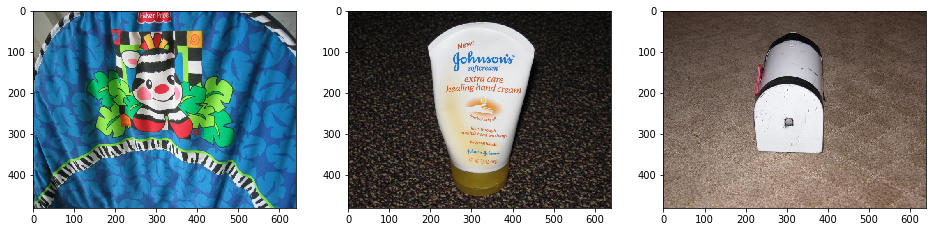

In [6]:
%matplotlib inline
results = {docs[i]: [docs[each] for each in val] for i, val in enumerate(indices)}
filenames = [f'{IMG_DIR_TRAIN}/0/{res}' for res in results['ukbench00120.jpg']]

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    with open(filenames[i],'rb') as f:
        image=Image.open(f)
        ax[i].imshow(image)
plt.show()

#### Return most similar images to - ukbench09348

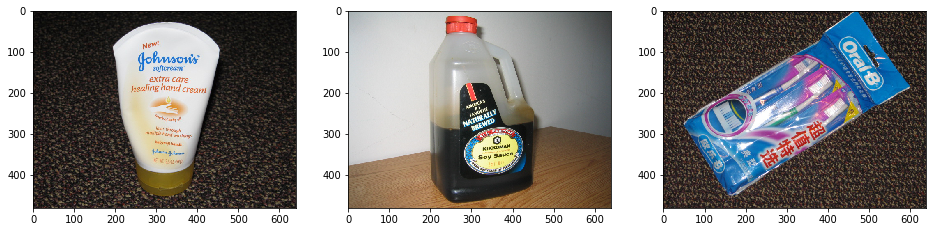

In [7]:
filenames = [f'{IMG_DIR_TRAIN}/0/{res}' for res in results['ukbench09348.jpg']]

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    with open(filenames[i],'rb') as f:
        image=Image.open(f)
        ax[i].imshow(image)
plt.show()